In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from datasets import Dataset, load_from_disk
import torch.nn.functional as F

import numpy as np
import pandas as pd

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
path_final_test = './data/out_binary_test/'

In [4]:
BATCH_SIZE = 128

In [5]:
preprocess = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])])

In [6]:
test_dataset = ImageFolder(path_final_test, preprocess)

In [7]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 1683
    Root location: ./data/out_binary_test/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
testDataLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
next(iter(testDataLoader))[1]

tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 1])

## Naive:

In [10]:
resnet34 = models.resnet34(weights=None)
class CustomFC(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.fc1 = nn.Linear(in_features=in_features, out_features=out_features)
        
    def forward(self, x):
        return self.fc1(x), x
    
resnet34.fc = CustomFC(512,8)
resnet34.to(device)

resnet34.load_state_dict(torch.load('model_best_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [11]:
def naive_mod_acc(model, dataloader_test):
    model.eval()
    trg = []
    pred = []
    acc_test = 0.0
    tot_test = 0.0
    big_ones = 0.0
    tot_positive = 0.0
    with torch.no_grad():
        for itms in dataloader_test:
            x=itms[0]
            target=itms[1]
            x = x.to(device)
            target = target.to(device)
            outputs, _ = model(x)
            outputs = outputs.sigmoid().max(dim=1).values
            # print(outputs.shape)
            acc_test += torch.sum(outputs.round() == target).item()
            big_ones += torch.sum(outputs.round()).item()
            pred.extend(outputs.round().cpu().tolist())
            trg.extend(target.cpu().tolist())
            tot_test += target.size(0)
            tot_positive += torch.sum(target).item()
        print(f'Test accuracy: {round(acc_test/tot_test*100,2)}%')
        print(f'Higher than 50%: {round(big_ones/tot_test*100,2)}%')
        print(f'Non-anomalies to total: {round(tot_positive/tot_test*100,2)}%')
        
    return round(acc_test/tot_test*100,2), round(big_ones/tot_test*100,2), pd.DataFrame({'true':trg, 'pred':pred})

In [12]:
_,_, res = naive_mod_acc(resnet34, testDataLoader)
res

Test accuracy: 50.74%
Higher than 50%: 97.68%
Non-anomalies to total: 49.97%


,true,pred
0,0,1.0
1,1,1.0
2,1,1.0
3,0,1.0
4,1,1.0
...,...,...
1678,1,1.0
1679,0,1.0
1680,0,1.0
1681,0,1.0


## Autoencoder

In [13]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n, m, p, b):
        super().__init__()
        self.e1 = torch.nn.Linear(n, m)
        self.e2 = torch.nn.Linear(m, p)
        self.e3 = torch.nn.Linear(p, b)
        self.dec3 = torch.nn.Linear(b, p)
        self.dec2 = torch.nn.Linear(p, m)
        self.dec1 = torch.nn.Linear(m, n)
        
    def forward(self, x):
        x = self.e1(x)
        x = self.e2(F.relu(x))
        encoded = self.e3(F.relu(x))
        x = self.dec3(encoded)
        x = self.dec2(F.relu(x))
        x = self.dec1(F.relu(x))
        return x

model_auto = AutoEncoder(512, 256, 128, 32)
model_auto.to(device)
model_auto.load_state_dict(torch.load('best_model_autoenc32_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [14]:
def multy_mod_acc(model1, model2, dataloader_test, er_mean_rat=1.3):
    loss_fn = torch.nn.MSELoss(reduction='none')
    model1.eval()
    model2.eval()
    trg = []
    pred = []
    acc_test = 0.0
    tot_test = 0.0
    neg_ones = 0.0
    err_p = []
    err_n = []
    tot_positive = 0.0
    with torch.no_grad():
        for itms in dataloader_test:
            x=itms[0]
            target=itms[1]
            x = x.to(device)
            target = target.to(device)
            outputs, emb = model1(x)
            x_pr = model2(emb)
            error = torch.mean(loss_fn(x_pr, emb), dim=1)
            prob = torch.exp(-torch.pow(error,2.)/(er_mean_rat*0.0026712)**2/2)
            outputs = (prob*outputs.sigmoid().max(dim=1).values)
            acc_test += torch.sum(outputs.round() == target).item()
            neg_ones += torch.sum((outputs.round() == target)&(target == 1)).item()
            err_p.extend(list(error[target==1].cpu().tolist()))
            err_n.extend(list(error[target==0].cpu().tolist()))
            # acc_test += torch.sum(torch.where(error>er_mean_rat,0,1) == target).item()
            tot_test += target.size(0)
            # 
            
            # outputs = outputs.sigmoid().max(dim=1).values

        #     big_ones += torch.sum(outputs.round()).item()
        #     pred.extend(outputs.round().cpu().tolist())
        #     trg.extend(target.cpu().tolist())
        #     tot_test += target.size(0)
        #     tot_positive += torch.sum(target).item()
        # print(f'{er_mean_rat}Test accuracy: {round(acc_test/tot_test*100,2)}%')
        # print(f'Higher than 50%: {round(big_ones/tot_test*100,2)}%')
        # print(f'Non-anomalies to total: {round(tot_positive/tot_test*100,2)}%')
        
    return round(acc_test/tot_test*100,2), neg_ones/tot_test*2, err_p, err_n#, round(big_ones/tot_test*100,2), pd.DataFrame({'true':trg, 'pred':pred})

In [16]:
acc, acc_p, err_p, err_n = multy_mod_acc(resnet34, model_auto, testDataLoader)
acc, acc_p

(85.86, 0.7379679144385026)

In [18]:
multy_mod_acc(resnet34, model_auto, testDataLoader, er_mean_rat=(1.3+433/1000))[0:2]

(91.8, 0.8805704099821747)

In [ ]:
# (91.8, 0.9554367201426025)

(0.0005, 1)

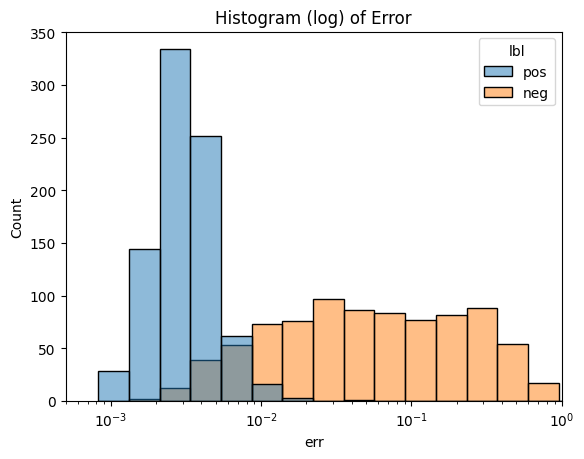

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

df1 = pd.DataFrame({'err':err_p})
df2 = pd.DataFrame({'err':err_n})
df1['lbl'] = 'pos'
df2['lbl'] = 'neg'
df = pd.concat([df1, df2], axis=0)

sns.histplot(data=df, x='err', hue='lbl', log_scale=True)
plt.title(f'Histogram (log) of Error')
plt.xlim(0.0005,1)

In [26]:
del model_auto

## VAE

In [20]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, latent_dim*2), # 2 for mean and variance.
        )
        # self.parametr = nn.Linear(latent_dim, 2 * latent_dim)
        self.softplus = nn.Softplus()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, input_dim),
        )
        
    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        # x = self.parametr(lat_x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)
        
        # compute loss terms 
        loss_recon = F.mse_loss(recon_x, x, reduction='none').sum(-1).sqrt()#.mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal)#.mean()
        # loss_kl = F.kl_div(z, lat_x, reduction='none').mean()
                
        loss = loss_recon + loss_kl
        
        return loss.mean(),loss_recon

model_auto1 = VAE(input_dim=512, hidden_dim=256, latent_dim=32).to(device)
model_auto1.load_state_dict(torch.load(f'best_model_var_autoenc32_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [21]:
def multy_mod_acc_var(model1, model2, dataloader_test, er_mean_rat=.7):
    loss_fn = torch.nn.MSELoss(reduction='none')
    model1.eval()
    model2.eval()
    trg = []
    pred = []
    acc_test = 0.0
    tot_test = 0.0
    neg_ones = 0.0
    tot_positive = 0.0
    with torch.no_grad():
        for itms in dataloader_test:
            x=itms[0]
            target=itms[1]
            x = x.to(device)
            target = target.to(device)
            outputs, emb = model1(x)
            error = model2(emb)[1]
            prob = 1-torch.exp(-torch.pow(error,2.)/(er_mean_rat*5.)**2/2)
            outputs = (prob*outputs.sigmoid().max(dim=1).values)
            acc_test += torch.sum(outputs.round() == target).item()
            neg_ones += torch.sum((outputs.round() == target)&(target == 1)).item()
            # acc_test += torch.sum(torch.where(error>er_mean_rat,0,1) == target).item()
            tot_test += target.size(0)
            # 
            
            # outputs = outputs.sigmoid().max(dim=1).values

        #     big_ones += torch.sum(outputs.round()).item()
        #     pred.extend(outputs.round().cpu().tolist())
        #     trg.extend(target.cpu().tolist())
        #     tot_test += target.size(0)
        #     tot_positive += torch.sum(target).item()
        # print(f'{er_mean_rat}Test accuracy: {round(acc_test/tot_test*100,2)}%')
        # print(f'Higher than 50%: {round(big_ones/tot_test*100,2)}%')
        # print(f'Non-anomalies to total: {round(tot_positive/tot_test*100,2)}%')
        
    return round(acc_test/tot_test*100,2), neg_ones/tot_test*2#, round(big_ones/tot_test*100,2), pd.DataFrame({'true':trg, 'pred':pred})



In [22]:
multy_mod_acc_var(resnet34, model_auto1, testDataLoader)

(43.37, 0.6904337492572786)

## AE simple

In [26]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, n, m, p, b):
        super().__init__()
        self.e1 = torch.nn.Linear(n, m)
        self.e2 = torch.nn.Linear(m, p)
        self.e3 = torch.nn.Linear(p, b)
        self.dec3 = torch.nn.Linear(b, p)
        self.dec2 = torch.nn.Linear(p, m)
        self.dec1 = torch.nn.Linear(m, n)
        
    def forward(self, x):
        x = self.e1(x)
        x = self.e2(F.relu(x))
        encoded = self.e3(F.relu(x))
        x = self.dec3(encoded)
        x = self.dec2(F.relu(x))
        x = self.dec1(F.relu(x))
        return x

model_auto = AutoEncoder(512, 256, 128, 32)
model_auto.to(device)
model_auto.load_state_dict(torch.load('best_model_autoenc32_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [29]:
def sep_mod_acc(model1, model2, dataloader_test, er_mean_rat=1.3):
    loss_fn = torch.nn.MSELoss(reduction='none')
    model1.eval()
    model2.eval()
    trg = []
    pred = []
    acc_test = 0.0
    tot_test = 0.0
    neg_ones = 0.0
    tot_positive = 0.0
    with torch.no_grad():
        for itms in dataloader_test:
            x=itms[0]
            target=itms[1]
            x = x.to(device)
            target = target.to(device)
            outputs, emb = model1(x)
            x_pr = model2(emb)
            error = torch.mean(loss_fn(x_pr, emb), dim=1)/0.0026712
            acc_test += torch.sum(torch.where(error>er_mean_rat,0,1) == target).item()
            neg_ones += torch.sum((torch.where(error>er_mean_rat,0,1) == target)&(target == 1)).item()
            tot_test += target.size(0)
            
            
            # outputs = outputs.sigmoid().max(dim=1).values

        #     big_ones += torch.sum(outputs.round()).item()
        #     pred.extend(outputs.round().cpu().tolist())
        #     trg.extend(target.cpu().tolist())
        #     tot_test += target.size(0)
        #     tot_positive += torch.sum(target).item()
        # print(f'{er_mean_rat}Test accuracy: {round(acc_test/tot_test*100,2)}%')
        # print(f'Higher than 50%: {round(big_ones/tot_test*100,2)}%')
        # print(f'Non-anomalies to total: {round(tot_positive/tot_test*100,2)}%')
        
    return round(acc_test/tot_test*100,2), neg_ones/tot_test*2#, round(big_ones/tot_test*100,2), pd.DataFrame({'true':trg, 'pred':pred})

In [30]:
sep_mod_acc(resnet34, model_auto, testDataLoader)

(80.39, 0.6250742721330956)